# General part

In [1]:
import subprocess
from pathlib import Path
import json
import os
from typing import Optional, List, Dict, Any, Literal, TypedDict, Annotated, Sequence
from langchain_core.tools import tool

## Imports

In [2]:
master_branch = 'main'
local_branch = 'feature/task-crud'
project_path_str = "/home/montare/projects/mini-tasker"
project_path = Path(project_path_str)
output = 'output.md'
MODEL='gemini-2.0-flash-lite'
# MODEL='qwen3:4b'

## Git functions

In [3]:
def get_changed_files():
    result = subprocess.run(
        ['git', 'diff', f'{master_branch}..{local_branch}', '--name-only'],
        cwd=project_path_str,
        check=True,
        capture_output=True,
        text=True
    )
    
    return result.stdout.strip().split('\n')

def get_changes(file_path: str):
    full_file_path = project_path / file_path
    
    result = subprocess.run(
        ['git', 'diff', f'{master_branch}..{local_branch}', '--', full_file_path],
        cwd=project_path_str,
        check=True,
        capture_output=True,
        text=True
    )
    
    return result.stdout.strip()

In [4]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

## File functions

In [5]:
@tool(parse_docstring=True)
def get_file_content(file_path: str):
    """
    Read the full contents of a specified source code file. 
    Use this to investigate file-level logic when regex-based search doesn't provide enough context.

    Args:
        file_path (str): Absolute or relative path to the file.

    Returns:
        str: Full contents of the file.
    """
    path_obj = Path(file_path)
    if path_obj.is_absolute():
        full_file_path = path_obj
    else:
        full_file_path = project_path / path_obj

    with open(full_file_path, "r", encoding="utf-8") as f:
        return f.read()

def get_file_size(file_path: str):
    path_obj = Path(file_path)
    if path_obj.is_absolute():
        full_file_path = path_obj
    else:
        full_file_path = project_path / path_obj

    return os.path.getsize(full_file_path)

## Splitter by size

In [6]:
def split_dict_by_token_limit(size_dict: dict, max_tokens: int = 5000):
    
    # Sort by size descending
    sorted_items = dict(
        # here x[1] is value of dict
        sorted(size_dict.items(), key = lambda x: x[1]['size'], reverse=True)
    )

    chunks = []  
    chunk_sizes = [] 

    for key, value in sorted_items.items():
        
        placed = False
        
        size = value['size']
        
        # Try placing in an existing chunk
        for i in range(len(chunks)):
            if chunk_sizes[i] + size <= max_tokens:
                
                chunk_sizes[i] += size # update chunk size
                
                chunks[i][key] = value # add a new record to chunk

                placed = True
                break

        # If no suitable chunk found, create a new one
        if not placed:
            chunks.append({key: value})
            chunk_sizes.append(size)

    return chunks


## Regex search in files

In [7]:
@tool(parse_docstring=True)
def regex_file_search(query: str, lines_of_code: Optional[int] = None):
    """
    Search the codebase using a regular expression and return matching lines with context.
    This tool uses ripgrep to find symbols like functions, classes, or variables 
    that may have been changed and are referenced elsewhere.

    Args:
        query (str): The regex pattern to search for.
        lines_of_code (int): Number of context lines to include before and after each match.

    Returns:
        list[str]: Matching lines with surrounding context.
    """
    pass
    args = [query]
    
    if lines_of_code:
        args.append(f'-C{lines_of_code}')

    args.append(project_path_str)
    # args.append('--no-filename')
    
    result = subprocess.run(
        ['rg'] + args,
        capture_output=True,
        encoding='utf-8',
    )

    if result.returncode == 0:
        return result.stdout
    elif result.returncode == 1:
        return "No matches found."
    else:
        return f"Error:\n{result.stderr}"

## Collect data in dict

In [8]:
files_dict = {}
changed_files = get_changed_files()

for file_path in changed_files:
    
    changes = get_changes(file_path)
    
    content = get_file_content.invoke(file_path)
    
    size = get_file_size(file_path)

    files_dict[file_path] = {
        "size": size,
        "changes": changes,
        "content": content
    }

In [9]:
size_dict = {
    key: {
        "size": value["size"]
    }
    for key, value in files_dict.items()
}

print("Changed files with sizes:")
size_dict

Changed files with sizes:


{'MiniTasker/settings.py': {'size': 3186},
 'MiniTasker/urls.py': {'size': 818},
 'tasks/migrations/0001_initial.py': {'size': 550},
 'tasks/models.py': {'size': 196},
 'tasks/urls.py': {'size': 139},
 'tasks/views.py': {'size': 562}}

## Chunk files

In [10]:
chunked_size_dict = split_dict_by_token_limit(size_dict)

chunked_files = split_dict_by_token_limit(files_dict)

print("Exampel of chunking by Token Limit:")
chunked_size_dict

Exampel of chunking by Token Limit:


[{'MiniTasker/settings.py': {'size': 3186},
  'MiniTasker/urls.py': {'size': 818},
  'tasks/views.py': {'size': 562},
  'tasks/models.py': {'size': 196},
  'tasks/urls.py': {'size': 139}},
 {'tasks/migrations/0001_initial.py': {'size': 550}}]

# AI part

In [11]:
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph,MessagesState, START, END
from langchain_google_vertexai import ChatVertexAI, VertexAIEmbeddings
from langchain_google_vertexai.llms import VertexAI
from langchain_ollama import ChatOllama
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain_core.tools import create_retriever_tool

## Get MCP client

In [12]:
client = MultiServerMCPClient(
    {
        "context7": {
            "command": "npx",
            "args": ["-y", "@upstash/context7-mcp"],
            "transport": "stdio"
        }
    }
)

mcp_tools = await client.get_tools()

## Prompt

In [28]:
prompt = """
### AI Code Review Agent System Prompt

You are a Code Review AI Agent responsible for analyzing Python code provided via `git diff` and full source content. 
Your task is to conduct **two levels of code review**: a detailed **line-by-line analysis** and a **cross-file consistency analysis** of a given file.

---

### Input

You will be provided with:

* `git_diff`: the unified diff of a modified Python file
* `file_content`: full content of that file

---

### Your Objectives

You must not only plan your code review, but also execute each step by calling tools directly as needed.
Do not output a static plan — instead, invoke tools to carry out your analysis step by step.

#### 1. Line-by-Line Static Code Review

Perform thorough **line-by-line analysis** of the provided file. Detect potential issues across the following categories:

* Threading & state safety
* Async/Await and context management
* File operations
* Error handling & edge cases
* Loop logic, conditionals, and branching
* Resource and variable state management
* State machine logic
* Dependency analysis
* Security risks
* Performance bottlenecks
* Type consistency
* Deprecated/incorrect libraries usage
* Data transfer (API, serialization, etc.)
* Business logic correctness
* Architectural decision validation
* Naming conventions and code stylistics

**Tool: context7 (MCP server)**
Use this tool to **look up external documentation or clarify behavior of libraries** (e.g., to confirm whether a function is async-safe, deprecated, or misused).

---

#### 2. Cross-File Consistency Analysis

Your goal is to **ensure code modifications are compatible across the entire codebase**. This includes:

* Identifying **renamed/modified/deleted functions, APIs, classes** 
* Verifying those changes **do not break references** in other files
* Ensuring all usage points follow **updated parameters, return values, or behaviors**

---

### Output Format

Respond with a **structured list of issues**, one object per issue in the following format:

```json
[
  {
    "issue_type": "Error Handling",
    "severity": "High",
    "file_path": "src/utils/file_ops.py",
    "description": "The file is opened without using a context manager, which can lead to resource leaks.",
    "recommendation": "Use a 'with open(...) as f:' block to ensure the file is properly closed."
  },
  {
    "issue_type": "Cross-File Consistency",
    "severity": "Medium",
    "file_path": "api/routes/data.py",
    "description": "The renamed function `fetch_user_profile_v2` is still being referenced as `fetch_user_profile` elsewhere.",
    "recommendation": "Update all references to use `fetch_user_profile_v2`, or alias the function to preserve backward compatibility."
  }
]

### Before you start
Check if the file you are checking was already reviewed, if it is, skip it

"""

## Vector database

In [29]:
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings

EMBEDDING_MODEL='qwen3:4b'
vectorstore = Chroma(
    collection_name="knowledge_base",
    embedding_function=OllamaEmbeddings(model=EMBEDDING_MODEL),
)

# EMBEDDING_MODEL='gemini-embedding-001'
# vectorstore = Chroma(
#     collection_name="knowledge_base",
#     embedding_function=VertexAIEmbeddings(
#         model_name=EMBEDDING_MODEL
#     ),
# )



retriever = vectorstore.as_retriever()

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_internal_knowledge",
    """
    Retrieve architectural or stylistic guidance from internal vectorized knowledge.

    Use this to evaluate whether the code conforms to internal best practices,
    naming conventions, architecture standards, and domain-specific logic.

    Parameters:
        query (str): A description or snippet of code to match against internal patterns.

    Returns:
        str: Closest matching convention, example, or suggestion.
    """,
)

## Memory

In [30]:
from langchain_core.runnables import RunnableConfig
from typing_extensions import TypedDict
from langgraph.config import get_store
from langgraph.prebuilt import create_react_agent
from langgraph.store.memory import InMemoryStore
import uuid


store = InMemoryStore()


class ReviewedFile(TypedDict): 
    name: str

In [31]:
@tool(parse_docstring=True)
def mark_file_reviewed(reviewed_file: ReviewedFile, config: RunnableConfig) -> None:
    """
    Mark a file as reviewed to prevent duplicate processing.
    Should be called only after both line-by-line and cross-file analyses 
    are fully completed.

    Args:
        reviewed_file: The file metadata to mark reviewed.
        config: Agent runtime config (RunnableConfig).
    """
    
    store = get_store() # get store  
    
    task_id = config["configurable"].get("task_id")  # get task id from agent
    
    store.put(
        ("reviewed_files",), # collection 
        task_id,  # key
        reviewed_file # value
    )  # update files in memory
    
    return "Successfully marked file as reviewed."
    

@tool(parse_docstring=True)
def get_reviewed_files(config: RunnableConfig) -> list[str]:
    """
    Retrieve a list of all files already reviewed during the current review session.

    Args:
        config: Agent runtime config (RunnableConfig).
    
    Returns:
        list[str]: Paths of files marked as reviewed.
    """
    store = get_store() # get store  

    task_id = config["configurable"].get("task_id")  # get task id from agent

    store.get(("reviewed_files",), task_id).value


## Create Code Review Agent

In [60]:
from langgraph.types import Command
from dataclasses import dataclass

@dataclass
class CodeReviewOutput(TypedDict):
    issue_type: str
    severity: str
    file_path: str
    description: str
    recommendation: str
    reasoning: str

def create_llm():
    """Create and configure LLM instance"""

    return ChatVertexAI(
        model=MODEL,
        temperature=0
    )


    # return VertexAI(
    #     model_name=MODEL,
    #     temperature=0
    # )

    # return ChatOllama(
    #     model=MODEL,
    #     temperature=0,
    #     timeout=300,  # 5 minutes timeout
    #     num_predict=2048
    # )

def create_code_review_agent():

    code_review_agent = create_react_agent(
        create_llm(),
        tools=[
            regex_file_search, # my file tools
            get_file_content,  
            retriever_tool, # rag tools
            mark_file_reviewed, # memory tools
            get_reviewed_files
        ],
        # + mcp_tools, todo: add mcp tools later
        
        store=store,
        response_format=CodeReviewOutput,
        name='code_reviewer',
        prompt=prompt
    )
    
    return code_review_agent

## Run agents

In [68]:
import asyncio 
from queue import Queue

raw_messages = Queue()  
structured_messages = Queue()  

task_id = uuid.uuid4()

async def start_analyzing(agent, content, task_id):
    messages = await agent.ainvoke(
        {
            "messages": [
                {
                    "role": "user",
                    "content": content,
                }
            ],
    
            "config" : {
                "configurable": { # config for memory
                    "task_id": task_id
                }
            }  
    
        }
    )
    
    try:    
        structured_response = messages['structured_response']
    except:
        print('no structured response')
        print('messages count', len(messages))
        print('messages keys: ', messages.keys())
        print('full messages', messages)
                
    raw_messages.put(messages)
    structured_messages.put(structured_response)
    
    return messages
        

async with (
    asyncio.TaskGroup() as tg
):

    print("Created task group.")

    for file_name, value in files_dict.items():

        if not value['changes']:
            print("Changes is empty!")
            break
            
        if not value['content']:
            print("Changes is empty!")
            break
        
        code_review_agent = create_code_review_agent()
        tg.create_task(start_analyzing(
            agent=code_review_agent,
            content="Analyze this file. Changes: " + value['changes'] + " File content: " + value['content'],
            task_id=task_id
        ))

        print(f"Task for file {file_name} started")

print('Agents finished the tasks!')

Created task group.
Task for file MiniTasker/settings.py started
Task for file MiniTasker/urls.py started
Task for file tasks/migrations/0001_initial.py started
Task for file tasks/models.py started
Task for file tasks/urls.py started
Task for file tasks/views.py started
Agents finished the tasks!


In [70]:
while not structured_messages.empty():
        message = structured_messages.get()
        print("Structured Message: ", message)

Structured Message:  {'recommendation': 'Add input validation to ensure the data provided to create the Task object is valid (e.g., check the title length, etc.).', 'description': 'The code creates a new Task object without any validation of the input data.', 'reasoning': 'The code creates a new Task object without any validation of the input data.', 'issue_type': 'Business Logic Correctness', 'severity': 'Medium', 'file_path': 'tasks/views.py'}
Structured Message:  {'recommendation': 'Add a newline character at the end of the file.', 'severity': 'Low', 'reasoning': "It's generally good practice to end files with a newline.", 'issue_type': 'Code Style', 'description': "The file ends without a newline character. While not strictly an error, it's generally good practice to end files with a newline.", 'file_path': 'tasks/urls.py'}
Structured Message:  {'recommendation': "Ensure the 'tasks' app exists and its 'urls.py' file is correctly configured with appropriate views and URL patterns.  

In [71]:
structured_output_dummy = [
    {'recommendation': 'Add input validation to ensure the data provided to create the Task object is valid (e.g., check the title length, etc.).', 'description': 'The code creates a new Task object without any validation of the input data.', 'reasoning': 'The code creates a new Task object without any validation of the input data.', 'issue_type': 'Business Logic Correctness', 'severity': 'Medium', 'file_path': 'tasks/views.py'},
    {'recommendation': 'Add a newline character at the end of the file.', 'severity': 'Low', 'reasoning': "It's generally good practice to end files with a newline.", 'issue_type': 'Code Style', 'description': "The file ends without a newline character. While not strictly an error, it's generally good practice to end files with a newline.", 'file_path': 'tasks/urls.py'},
    {'recommendation': "Ensure the 'tasks' app exists and its 'urls.py' file is correctly configured with appropriate views and URL patterns.  Verify the views referenced in tasks/urls.py exist and are correctly implemented.", 'severity': 'Medium', 'reasoning': 'The change adds a new URL pattern that includes another URL configuration. This requires checking the existence and configuration of the included URL configuration.', 'issue_type': 'Cross-File Consistency', 'description': "Added inclusion of 'tasks.urls'.  Requires verification that the 'tasks' app and its 'urls.py' file are correctly configured.", 'file_path': 'MiniTasker/urls.py'},
    {'recommendation': 'No action needed.', 'description': "The 'tasks' app was added to INSTALLED_APPS. This is a standard practice for including a new app in a Django project.", 'reasoning': "The addition of the 'tasks' app to INSTALLED_APPS is a common and correct practice when integrating a new Django app into a project. No immediate issues are apparent.", 'issue_type': 'None', 'severity': 'None', 'file_path': 'MiniTasker/settings.py'},
    {'recommendation': 'Review the file for style consistency, and consider using a code formatter like Black or autopep8 to automatically format the code.', 'description': "Ensure that the generated code adheres to the project's coding style guidelines. Check for consistent indentation, spacing, and line lengths.", 'reasoning': 'This file was generated by Django.', 'issue_type': 'Code Style', 'severity': 'Low', 'file_path': 'tasks/migrations/0001_initial.py'},
    {'recommendation': "Implement input validation to sanitize and validate the data received in the POST request. Use Django's built-in form validation or a library like `django-rest-framework` for robust validation.", 'description': 'The `create_task` view does not validate the input data. This makes the application vulnerable to various attacks, such as SQL injection (if the title is used in a database query) or other data-related vulnerabilities.', 'reasoning': 'The code directly uses the data from the request body without any validation.', 'issue_type': 'Security', 'severity': 'High', 'file_path': 'tasks/views.py'}
]
# ## Explore shared_messages
# structured_messages
# for message in raw_messages:
#     print("Message: ", message)

In [72]:
structured_output_dummy

[{'recommendation': 'Add input validation to ensure the data provided to create the Task object is valid (e.g., check the title length, etc.).',
  'description': 'The code creates a new Task object without any validation of the input data.',
  'reasoning': 'The code creates a new Task object without any validation of the input data.',
  'issue_type': 'Business Logic Correctness',
  'severity': 'Medium',
  'file_path': 'tasks/views.py'},
 {'recommendation': 'Add a newline character at the end of the file.',
  'severity': 'Low',
  'reasoning': "It's generally good practice to end files with a newline.",
  'issue_type': 'Code Style',
  'description': "The file ends without a newline character. While not strictly an error, it's generally good practice to end files with a newline.",
  'file_path': 'tasks/urls.py'},
 {'recommendation': "Ensure the 'tasks' app exists and its 'urls.py' file is correctly configured with appropriate views and URL patterns.  Verify the views referenced in tasks/u

In [75]:
## Summarize changes

summarizer = create_llm()
response = await summarizer.ainvoke("Summarize the changes and give the output: " + json.dumps(structured_output_dummy))

In [76]:
print(response.content)

This analysis identifies several areas for improvement in a Django project, focusing on security, code style, and project setup. Here's a summary of the changes and their implications:

**Changes and Recommendations:**

*   **tasks/views.py:**
    *   **Recommendation 1:** Add input validation to the `create_task` view to ensure the data used to create a `Task` object is valid (e.g., title length).
    *   **Recommendation 2:** Implement input validation to sanitize and validate the data received in the POST request. Use Django's built-in form validation or a library like `django-rest-framework` for robust validation. This is a **High** severity security issue.
*   **tasks/urls.py:** Add a newline character at the end of the file.
*   **MiniTasker/urls.py:** Added inclusion of 'tasks.urls'. Requires verification that the 'tasks' app and its 'urls.py' file are correctly configured.
*   **MiniTasker/settings.py:** The 'tasks' app was added to INSTALLED\_APPS. This is a standard practice.

## Create graph

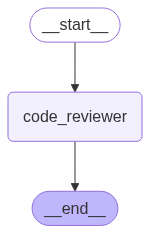

In [36]:
code_review_agent = create_code_review_agent()

graph = StateGraph(MessagesState)
graph.add_node(code_review_agent)

# graph.add_node("check_completion", check_completion)

graph.add_edge(START, "code_reviewer")

# graph.add_edge("code_reviewer", "check_completion")
# graph.add_edge("check_completion", END)

graph.add_edge("code_reviewer", END)

# graph.add_conditional_edges(
#     "review_checker", 
#     check_completion, 
#     {
#         "incomplete": "code_reviewer", 
#         "complete": END
#     }
# )

app = graph.compile()


from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

## Run graph

In [37]:
task_id = uuid.uuid4()

for file_name, value in files_dict.items():
    break

print(f'Analyzing {file_name}...')

async for chunk in app.astream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Analyze this file. Changes: " + value['changes'] + " File content: " + value['content'],
            }
        ],

        "config" : {
            "configurable": { # config for memory
                "task_id": task_id
            }
        }  

    },
):
    pretty_print_messages(chunk)

print("finished")

Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring


Analyzing MiniTasker/settings.py...


Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring


Update from node code_reviewer:


================================ Human Message =================================

Analyze this file. Changes: diff --git a/MiniTasker/settings.py b/MiniTasker/settings.py
index 393fbfd..d2609eb 100644
--- a/MiniTasker/settings.py
+++ b/MiniTasker/settings.py
@@ -37,6 +37,7 @@ INSTALLED_APPS = [
     'django.contrib.sessions',
     'django.contrib.messages',
     'django.contrib.staticfiles',
+    'tasks',
 ]
 
 MIDDLEWARE = [ File content: """
Django settings for MiniTasker project.

Generated by 'django-admin startproject' using Django 5.2.3.

For more information on this file, see
https://docs.djangoproject.com/en/5.2/topics/settings/

For the full list of settings and their values, see
https://docs.djangoproject.com/en/5.2/ref/settings/
"""

from pathlib import Path

# Build paths inside the project like this: BASE_DIR / 'subdir'.
BASE_DIR = Path(__file__).resolve().parent.parent


# Quick-start development settings - unsuitable for production
# See

In [38]:
final_message_history = chunk["code_reviewer"]["messages"]
for message in final_message_history:
    message.pretty_print()

================================ Human Message =================================

Analyze this file. Changes: diff --git a/MiniTasker/settings.py b/MiniTasker/settings.py
index 393fbfd..d2609eb 100644
--- a/MiniTasker/settings.py
+++ b/MiniTasker/settings.py
@@ -37,6 +37,7 @@ INSTALLED_APPS = [
     'django.contrib.sessions',
     'django.contrib.messages',
     'django.contrib.staticfiles',
+    'tasks',
 ]
 
 MIDDLEWARE = [ File content: """
Django settings for MiniTasker project.

Generated by 'django-admin startproject' using Django 5.2.3.

For more information on this file, see
https://docs.djangoproject.com/en/5.2/topics/settings/

For the full list of settings and their values, see
https://docs.djangoproject.com/en/5.2/ref/settings/
"""

from pathlib import Path

# Build paths inside the project like this: BASE_DIR / 'subdir'.
BASE_DIR = Path(__file__).resolve().parent.parent


# Quick-start development settings - unsuitable for production
# See https://docs.djangoproject.com/en

In [51]:
chunk["code_reviewer"]['messages'][-1]

AIMessage(content='I am unable to mark the file as reviewed. However, I have completed the code review and identified the relevant issues.\n\n```json\n[\n  {\n    "issue_type": "Cross-File Consistency",\n    "severity": "Low",\n    "file_path": "MiniTasker/settings.py",\n    "description": "The \'tasks\' app has been added to INSTALLED_APPS. Further checks are needed to ensure the app is correctly configured (urls, models, views).",\n    "recommendation": "Verify the implementation of the \'tasks\' app, including its models, views, and URLs, to ensure it functions as intended."\n  }\n]\n```', additional_kwargs={}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 3313, 'candidates_token_count': 147, 'total_token_count': 3460, 'prompt_tokens_details': [{'modality': 1, 'token_count': 3313}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 147}], 'thoughts_token_count': 0, 'cached_content_token_count': 0, 'cache_tokens_deta

In [52]:
elements = extract_and_parse_json(chunk["code_reviewer"]['messages'][-1].content)

In [53]:
type(elements[0])

dict

In [54]:
elements[0]

{'issue_type': 'Cross-File Consistency',
 'severity': 'Low',
 'file_path': 'MiniTasker/settings.py',
 'description': "The 'tasks' app has been added to INSTALLED_APPS. Further checks are needed to ensure the app is correctly configured (urls, models, views).",
 'recommendation': "Verify the implementation of the 'tasks' app, including its models, views, and URLs, to ensure it functions as intended."}